# Part 0: Set up and Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
import gc

from collections import OrderedDict
from base64 import b64encode
from sklearn.model_selection import train_test_split

import torch
import torch.optim as optim
from torch.utils.data import Dataset, random_split, DataLoader

import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models

import nibabel as nib
from PIL import Image

import cv2
from IPython.display import HTML
from IPython.display import Video

import matplotlib.pyplot as plt
from matplotlib import animation, rc
import matplotlib.cm as cm
import matplotlib.animation as animation
from matplotlib.animation import ArtistAnimation

%matplotlib inline
plt.rcParams['animation.embed_limit'] = 100

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Mon Apr 15 01:26:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              46W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

# Part 1: Dataset


## Part 1 - 1: Med-Image-Dataset Definition

In [4]:
class MedicalImageDataset(Dataset):
    def __init__(self, image_paths, label_paths, data_augment):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.data_augment = data_augment
        self.transform = transforms.Compose([
            transforms.Resize((224, 224), interpolation=Image.BILINEAR),
            transforms.ToTensor(), # This already does normalization to [0, 1]!
        ])
        self.cache = {}  # Cache for loaded videos
        self.number_of_paths = len(self.image_paths)

        self.index_map = []
        total_frames = 0
        for image_path in image_paths:
            image = nib.load(image_path).get_fdata()
            total_frames += image.shape[2]
            self.index_map.append(total_frames)

        self.length = total_frames

    def __len__(self):
        return self.length

    def get_video(self, idx):
        if idx in self.cache:
            return self.cache[idx]

        image_path = self.image_paths[idx]
        label_path = self.label_paths[idx]
        image = nib.load(image_path).get_fdata()
        label = nib.load(label_path).get_fdata()

        self.cache[idx] = (image, label)
        return image, label

    def __getitem__(self, idx):
        if idx >= self.length:
            raise IndexError("Index out of range")

        video_index = next(i for i, total in enumerate(self.index_map) if total > idx)
        frame_index = idx - (self.index_map[video_index - 1] if video_index > 0 else 0)

        image, label = self.get_video(video_index)

        frame_image = image[:, :, frame_index] # np.array, (h, w)
        frame_label = label[:, :, frame_index] # np.array, (h, w)

        if self.data_augment:
            # Data augmentation
            if np.random.rand() > 0.5:
                # print(f'idx [{idx}], random flipped') # For Proof of Data Augmentation
                ax = np.random.choice([0,1])
                frame_image = np.flip(frame_image, axis=ax)
                frame_label = np.flip(frame_label, axis=ax)

            if np.random.rand() > 0.5:
                # print(f'idx [{idx}], random rotation') # For Proof of Data Augmentation
                rot = np.random.choice([1,2,3]) # 90, 180, or 270 degrees

                frame_image = np.rot90(frame_image, rot, axes=[0,1])
                frame_label = np.rot90(frame_label, rot, axes=[0,1])

        image_pil = Image.fromarray(frame_image)
        label_pil = Image.fromarray(frame_label)

        transformed_image = self.transform(image_pil).transpose(0,1).transpose(1,2).squeeze()
        transformed_label = self.transform(label_pil).transpose(0,1).transpose(1,2).squeeze()

        return transformed_image, transformed_label


    def log(self):
        image, label = self.get_video(0) # first data in this dataset

        # Convert tensors back to numpy arrays for visualization
        image_at_0 = image
        label_at_0 = label

        dataset_len = self.number_of_paths

        image_min = np.min(image_at_0)
        image_max = np.max(image_at_0)
        label_min = np.min(label_at_0)
        label_max = np.max(label_at_0)

        # Scan over the dataset
        for i in range(dataset_len):
            image, label = self.get_video(i)
            image_np = image
            label_np = label

            if image_np.shape != image_at_0.shape:
                print(f'image shape mismatch: {i}th: {image_np.shape} vs 0th: {image_at_0.shape}')
            if label_np.shape != label_at_0.shape:
                print(f'label shape mismatch: {i}th: {label_np.shape} vs 0th: {label_at_0.shape}')
            if image_np.shape != label_np.shape:
                print(f'{i}th pair shape mismatch: image: {image_np.shape} vs label: {label_np.shape}')

            if image_min > np.min(image_np):
                image_min = np.min(image_np)

            if image_max < np.max(image_np):
                image_max = np.max(image_np)

            if label_min > np.min(label_np):
                label_min = np.min(label_np)

            if label_max < np.max(label_np):
                label_max = np.max(label_np)


        # Log
        print(f'[Total] {dataset_len} pairs')
        print(f'[Image] min: {image_min}, max: {image_max}')
        print(f'[Label] min: {label_min}, max: {label_max}')

    def show_frame_3D(self, idx, dim2=0, is_label=False):
        image, label = self.get_video(idx)

        # Convert tensors back to numpy arrays for visualization
        image_np = image
        label_np = label

        # Visualize
        if not is_label:
            plt.figure(figsize=(6, 6))
            plt.imshow(image_np[:, :, dim2], cmap='gray')
            plt.title('Image')
            plt.show()
        else:
            plt.figure(figsize=(6, 6))
            plt.imshow(label_np[:, :, dim2], cmap='gray')
            plt.title('Label')
            plt.show()

    def show_frame_4D(self, idx, dim2=0, dim3=0, is_label=False):
        image, label = self.get_video(idx)

        # Convert tensors back to numpy arrays for visualization
        image_np = image
        label_np = label

        # Visualize
        if not is_label:
            plt.figure(figsize=(6, 6))
            plt.imshow(image_np[:, :, dim2, dim3], cmap='gray')
            plt.title('Image')
            plt.show()
        else:
            plt.figure(figsize=(6, 6))
            plt.imshow(label_np[:, :, dim2, dim3], cmap='gray')
            plt.title('Label')
            plt.show()

    def show_video_3D(self, idx, is_label=False):
        image, label = self.get_video(idx)

        # Convert tensors back to numpy arrays for visualization
        video_frames = label if is_label else image

        print(f"video_frames shape: {video_frames.shape}")

        frames = [] # for storing the generated images
        fig, ax = plt.subplots(figsize=(6, 6))  # Use subplots to get the axes

        for i in range(video_frames.shape[2]):
            frame = [plt.imshow(video_frames[:, :, i], cmap='gray', animated=True)]
            frames.append(frame)

        ani = ArtistAnimation(fig, frames, interval=50, blit=True, repeat_delay=1000)
        plt.close(fig)  # Prevents the static plot from showing

        return HTML(ani.to_jshtml())

    def show_video_4D(self, idx, last_dim=0, is_label=False):
        image, label = self.get_video(idx)

        # Convert tensors back to numpy arrays for visualization
        video_frames = label if is_label else image

        print(f"video shape: {video_frames.shape}")

        frames = [] # for storing the generated images
        fig, ax = plt.subplots(figsize=(6, 6))  # Use subplots to get the axes

        for i in range(video_frames.shape[2]):
            frame = [plt.imshow(video_frames[:, :, i, last_dim], cmap='gray', animated=True)]
            frames.append(frame)

        ani = ArtistAnimation(fig, frames, interval=50, blit=True, repeat_delay=1000)
        plt.close(fig)  # Prevents the static plot from showing

        return HTML(ani.to_jshtml())

In [49]:
def split_dataset(image_files, label_files, test_pct=0.2, val_pct=0.1, random_seed=42):
    """
    Splits the dataset into training, validation, and testing subsets.
    image_files: list of image file paths
    label_files: list of label file paths
    """
    # Split into training + val/test
    train_img, test_img, train_lbl, test_lbl = train_test_split(
        image_files, label_files, test_size=test_pct + val_pct, random_state=random_seed)

    # Split off validation set from the combined val/test set
    val_pct_adjusted = val_pct / (test_pct + val_pct)  # Adjust val_pct based on the reduced set size
    test_img, val_img, test_lbl, val_lbl = train_test_split(
        test_img, test_lbl, test_size=val_pct_adjusted, random_state=random_seed)

    return {
        'train': MedicalImageDataset(train_img, train_lbl, False),
        'val': MedicalImageDataset(val_img, val_lbl, False),
        'test': MedicalImageDataset(test_img, test_lbl, False)
    }

## Part 1 - 2: Task02 Heart Dataset Split

In [25]:
# How to unzip a tar file on Google Drive
# Ensure Google Drive has enough space left
# !tar -xvf '/content/drive/My Drive/413_Project/Med-Seg-Decathlon/Task05_Prostate.tar' -C '/content/drive/My Drive/413_Project/Med-Seg-Decathlon/'

In [26]:
task_dir_name = 'Task02_Heart'
starts_with = 'la'
images_dir = '/content/drive/My Drive/413_Project/Med-Seg-Decathlon/' + task_dir_name + '/imagesTr'
labels_dir = '/content/drive/My Drive/413_Project/Med-Seg-Decathlon/' + task_dir_name + '/labelsTr'

image_files = sorted([os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith('.nii.gz') and f.startswith(starts_with)]) # List for file paths
label_files = sorted([os.path.join(labels_dir, f) for f in os.listdir(labels_dir) if f.endswith('.nii.gz') and f.startswith(starts_with)]) # List for file paths

# datasets = split_dataset(image_files, label_files, test_pct=0.2, val_pct=0.1, random_seed=42)
datasets = split_dataset(image_files, label_files, test_pct=0.2, val_pct=0.1, random_seed=42)

# Accessing the split datasets
t2_train_dataset = datasets['train']
t2_val_dataset = datasets['val']
t2_test_dataset = datasets['test']

In [8]:
print(f'Number of train images: {t2_train_dataset.index_map[-1]}')
print(f'Number of val images: {t2_val_dataset.index_map[-1]}')
print(f'Number of test images: {t2_test_dataset.index_map[-1]}')

Number of train images: 1491
Number of val images: 370
Number of test images: 410


In [ ]:
################################################################################
################################################################################
################################################################################

# YOU CAN MOVE TO PART 2 or 3 After running code above this block!

################################################################################
################################################################################
################################################################################

## Part 1 - 3: [OPTIONAL] Proof of Data Augmentation

In [ ]:
# Proof of Data Augmentation's randomness
# YOU NEED TO UNCOMMENT the PRINT statements in __getitem__ to see the results
for i, (image, label) in enumerate(t2_train_dataset):
    if i == 20:
        break

In [ ]:
# Proof of Data Augmentation's randomness
# The result it different from the above
for i, (image, label) in enumerate(t2_train_dataset):
    if i == 20:
        break

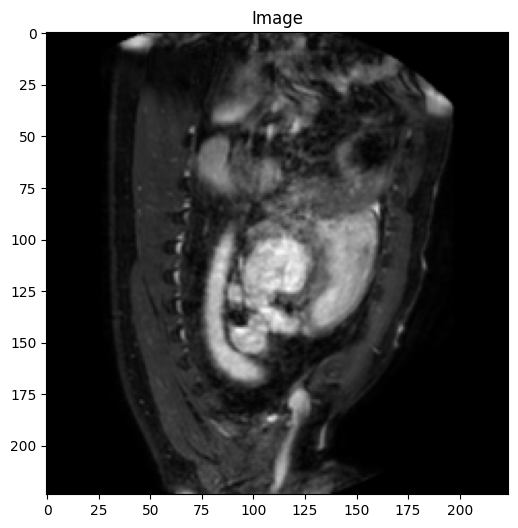

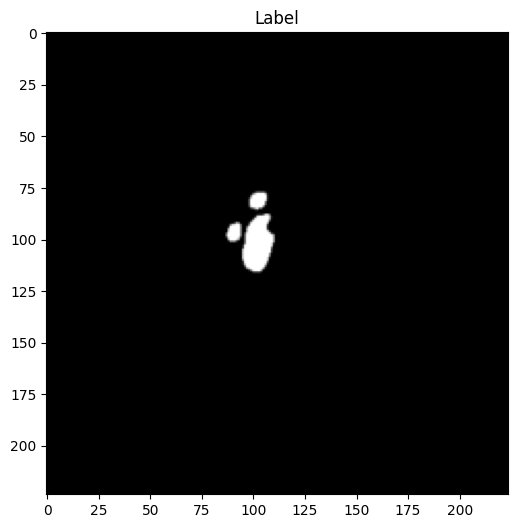

In [ ]:
# Proof of Data Augmentation with Images

# show_frame_3D() doesn't use __getitem()__, thus no flips or rotations
# Thus, to verify augmentation, manually show the array returned by getitem

plt.figure(figsize=(6, 6))
plt.imshow(t2_train_dataset[50][0], cmap='gray')
plt.title('Image');
plt.show()

plt.figure(figsize=(6, 6))
plt.imshow(t2_train_dataset[50][1], cmap='gray')
plt.title('Label')
plt.show()

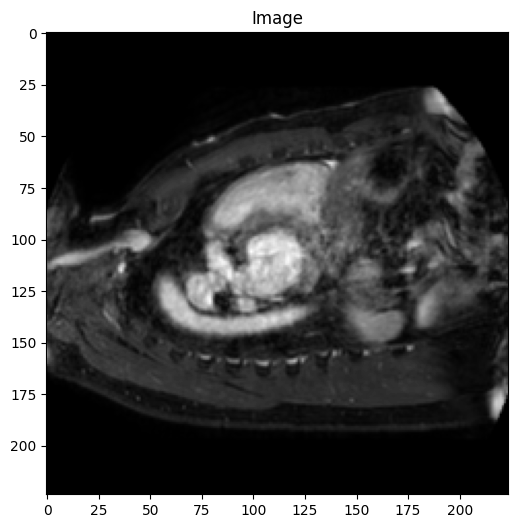

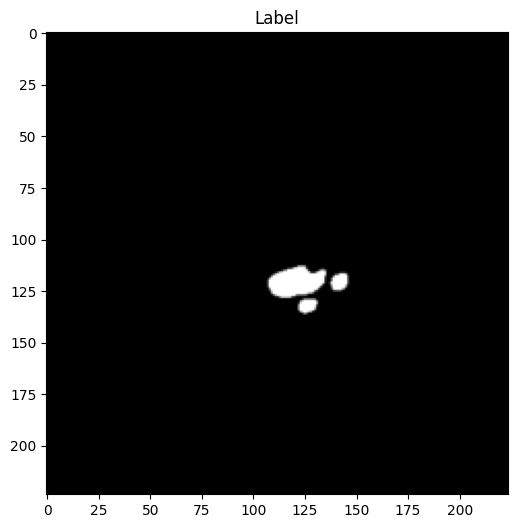

In [ ]:
# Proof of Data Augmentation with Images
# Same image with different orientation

plt.figure(figsize=(6, 6))
plt.imshow(t2_train_dataset[50][0], cmap='gray')
plt.title('Image');
plt.show()

plt.figure(figsize=(6, 6))
plt.imshow(t2_train_dataset[50][1], cmap='gray')
plt.title('Label')
plt.show()

## Part 1 - 4: [OPTIONAL] Task02 Heart Dataset Exploration

In [ ]:
print("### TASK2 TRAIN ###")
t2_train_dataset.log()
print()

print("### TASK2 VAL ###")
t2_val_dataset.log()
print()

print("### TASK2 TEST ###")
t2_test_dataset.log()
print()

### TASK2 TRAIN ###
image shape mismatch: 1th: (320, 320, 109) vs 0th: (320, 320, 130)
label shape mismatch: 1th: (320, 320, 109) vs 0th: (320, 320, 130)
image shape mismatch: 2th: (320, 320, 120) vs 0th: (320, 320, 130)
label shape mismatch: 2th: (320, 320, 120) vs 0th: (320, 320, 130)
image shape mismatch: 3th: (320, 320, 100) vs 0th: (320, 320, 130)
label shape mismatch: 3th: (320, 320, 100) vs 0th: (320, 320, 130)
image shape mismatch: 4th: (320, 320, 120) vs 0th: (320, 320, 130)
label shape mismatch: 4th: (320, 320, 120) vs 0th: (320, 320, 130)
image shape mismatch: 5th: (320, 320, 120) vs 0th: (320, 320, 130)
label shape mismatch: 5th: (320, 320, 120) vs 0th: (320, 320, 130)
image shape mismatch: 6th: (320, 320, 110) vs 0th: (320, 320, 130)
label shape mismatch: 6th: (320, 320, 110) vs 0th: (320, 320, 130)
image shape mismatch: 7th: (320, 320, 100) vs 0th: (320, 320, 130)
label shape mismatch: 7th: (320, 320, 100) vs 0th: (320, 320, 130)
image shape mismatch: 8th: (320, 320, 110)

In [ ]:
t2_train_dataset.show_frame_3D(3, 10, is_label=False) # Choosing 10th frame of the 3rd data
t2_train_dataset.show_frame_3D(3, 10, is_label=True)  # Choosing 10th frame of the 3rd data

In [ ]:
t2_train_dataset.show_frame_3D(3, 50, is_label=False) # Choosing 50 as the frames in the middle usually have a label
t2_train_dataset.show_frame_3D(3, 50, is_label=True)  # Choosing 50 as the frames in the middle usually have a label

In [ ]:
t2_train_dataset.show_video_3D(0, is_label=False)

In [ ]:
t2_train_dataset.show_video_3D(0, is_label=True)

## Part 1 - 5: Task05 Prostate Dataset Split


In [ ]:
task_dir_name = 'Task05_Prostate'
starts_with = 'prostate'
images_dir = '/content/drive/My Drive/413_Project/Med-Seg-Decathlon/' + task_dir_name + '/imagesTr'
labels_dir = '/content/drive/My Drive/413_Project/Med-Seg-Decathlon/' + task_dir_name + '/labelsTr'

image_files = sorted([os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith('.nii.gz') and f.startswith(starts_with)]) # List for file paths
label_files = sorted([os.path.join(labels_dir, f) for f in os.listdir(labels_dir) if f.endswith('.nii.gz') and f.startswith(starts_with)]) # List for file paths

datasets = split_dataset(image_files, label_files, test_pct=0.2, val_pct=0.1, random_seed=42)
# datasets = split_dataset(image_files, label_files, test_pct=0.2, val_pct=0.1, random_seed=42, train_transform=train_transform, val_transform=val_transform, test_transform=test_transform)

# Accessing the split datasets
t5_train_dataset = datasets['train']
t5_val_dataset = datasets['val']
t5_test_dataset = datasets['test']

print("### TASK5 TRAIN ###")
t5_train_dataset.log()
print()

print("### TASK5 VAL ###")
t5_val_dataset.log()
print()

print("### TASK5 TEST ###")
t5_test_dataset.log()
print()

In [ ]:
# 10th frame of the 0th data
t5_train_dataset.show_frame_4D(0, 10, 0, is_label=False) # 4D for train image
t5_train_dataset.show_frame_4D(0, 10, 1, is_label=False) # 4D for train image
t5_train_dataset.show_frame_3D(0, 10, is_label=True) # 3D for label => "has grey regions"

In [ ]:
t5_train_dataset.show_video_4D(0, last_dim=0,is_label=False)

In [ ]:
t5_train_dataset.show_video_4D(0, last_dim=1,is_label=False)

In [ ]:
t5_train_dataset.show_video_3D(0, is_label=True)

# Part 2: [OPTIONAL] Show Batch

In [ ]:
########################################
# Dataloaders are re-initiliazed in Part3
########################################

# Test Dataloader with MedicalImageDataset.__getitem__
part2_batch_size = 16 # 64 to 16

# Create DataLoaders
part2_t2_train_dl = DataLoader(t2_train_dataset, part2_batch_size, shuffle=True, num_workers=2, pin_memory=True)
part2_t2_val_dl = DataLoader(t2_val_dataset, part2_batch_size, num_workers=2, pin_memory=True)
part2_t2_test_dl = DataLoader(t2_test_dataset, part2_batch_size, num_workers=2, pin_memory=True)

In [ ]:
# Function for verifying the behavior of Dataloader. Not used int Part 3

def show_batch(dl):
    for img, lb in dl:
        print(img.shape)
        # Transpose to get [batch_size, channels, height, width]
        # img = img.transpose(0, 1).transpose(1, 2) # This line is needed because DL changes (224,224) to (batch, 224, 224)
        # lb = lb.transpose(0, 1).transpose(1, 2)

        # Set up the figure size
        plt.figure(figsize=(15, 15))

        # Loop to plot the images
        for i in range(64):
            plt.subplot(8, 8, i+1)  # (8, 8) grid and the index of the subplot
            # plt.imshow(img[:, :, i], cmap='gray')  # Assuming the images are grayscale
            plt.imshow(img[i, :, :], cmap='gray')
            plt.axis('off')  # To not display the axes

        plt.tight_layout()
        plt.show()
        break

In [ ]:
show_batch(part2_t2_train_dl)

In [ ]:
show_batch(part2_t2_val_dl)

In [ ]:
show_batch(part2_t2_test_dl)

# Part 3: Training the Model

In [9]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.8 MB/s eta 0:00:00


In [10]:
from tqdm import tqdm
import wandb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

device: cuda


## Part 3 - 1: DiceLoss Definition


In [37]:
class DiceLoss(nn.Module):
    def __init__(self, channel=1):
        super(DiceLoss, self).__init__()
        self.channel = channel

    def forward(self, predicted, target):
        predicted = torch.sigmoid(predicted[:, self.channel, :, :])
        predicted = predicted.view(predicted.size(0), -1)
        target = target.view(target.size(0), -1)

        intersection = (predicted * target).sum(dim=1)
        union = predicted.sum(dim=1) + target.sum(dim=1)
        dice_score = (2. * intersection + 1e-6) / (union + 1e-6)

        return 1 - dice_score.mean()


def dice_coefficient(predicted, target, log=False, channel=1):
    predicted = torch.sigmoid(predicted[:, channel, :, :])  # Get the probabilities for the foreground class
    predicted = (predicted > 0.5).float()
    predicted = predicted.view(predicted.size(0), -1)
    target = target.view(target.size(0), -1)

    intersection = (predicted * target).sum(dim=1)
    union = predicted.sum(dim=1) + target.sum(dim=1)
    dice_score = (2. * intersection + 1e-6) / (union + 1e-6)

    if log == True:
        print(f'target: {target.sum(dim=1)}')
        print(f'predicted: {predicted.sum(dim=1)}')
        print(f'union: {union}')
        print(f'intersection: {intersection}')

    return dice_score.mean()

## Part 3 - 2: Model definition

In [12]:
from transformers import SegformerForSemanticSegmentation, SegformerConfig
from transformers.models.segformer.modeling_segformer import SegformerMLP

## Part 3 - 3: Model Initialization and Parameter Info Log

In [56]:
# Befor you re-run the train loop, you must run this block and the blocks between the loop
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b2")

# Check model parameter counts
pytorch_total_params = sum(p.numel() for p in model.parameters()) # 3221538
print(f'total params: {pytorch_total_params}')
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'total trainable params: {pytorch_total_params}')

# Freeze all parameters first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last layer
for param in model.decode_head.parameters():
    param.requires_grad = True

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b2 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


total params: 28115624
total trainable params: 28115624


## Part 3 - 3: Hyperparameter Setting


In [57]:
# Train hyperparameters
batch_size = 8 # 8 or 16 seems to be effective
epochs = 50
lr = 0.001
patience = 10 # Set this to epochs if you want to test train set overfitting
min_delta = 0.01 # The value used to determine whether val loss is decreasing by at least min_delta or not for early stopping

criterion = DiceLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=1e-5)
# Create DataLoaders: we remove the task specific prefix here
num_workers = 0
train_dl = DataLoader(t2_train_dataset, batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_dl = DataLoader(t2_val_dataset, batch_size, num_workers=num_workers, pin_memory=True)
test_dl = DataLoader(t2_test_dataset, batch_size, num_workers=num_workers, pin_memory=True)

# Log Parameter Info
frozen = 0
unfrozen = 0

for param in model.parameters():
    if param.requires_grad:
        unfrozen += 1

    else:
        frozen += 1

print(f'frozen: {frozen}, unfrozen: {unfrozen}')
if unfrozen == 0:
    print("There are no trainable parameters")

frozen: 364, unfrozen: 13


## Part 3 - 4: Train Loop


In [58]:
# Garbage Collection
torch.cuda.empty_cache()
gc.collect()

# Initialize Weights & Biases: 6a41c40efc5a46c6f10b47ab94166b5d55ba4809
wandb.init(project='task2-segformer-data_augment', name='train_early_stop_data_augmented') # TODO: modify the header!!

best_loss = float('inf')
patience_counter = 0

# Model to device, Set the model to training mode
model.to(device)
model.train()

# Train for epochs
for epoch in range(epochs):
    train_total_loss = 0 # sum of all losses of all batches in train set
    train_num_batch = 0 # number of batches

    progress_bar = tqdm(train_dl, desc=f'Epoch {epoch+1}/{epochs}')
    for img, lb in progress_bar:
        img = img.to(device)
        lb = lb.to(device).long()
        img_rgb = img.unsqueeze(1).repeat(1, 3, 1, 1)

        optimizer.zero_grad()
        output = model(pixel_values=img_rgb, labels=lb)
        iou_loss, logits = output.loss, output.logits
        upsampled_logits = nn.functional.interpolate(logits, size=lb.shape[-2:], mode="bilinear", align_corners=False)

        # Do not threshold here; use the raw output directly for loss calculation
        loss = criterion(upsampled_logits, lb)
        loss.backward()
        optimizer.step()

        train_total_loss += loss.item()
        train_num_batch += 1

        train_avg_loss = train_total_loss / train_num_batch

    wandb.log({'epoch': epoch, 'train_loss': train_avg_loss})
    torch.cuda.empty_cache()

    # Validation and early stopping
    model.eval()
    with torch.no_grad():
        val_total_loss = 0
        val_num_batch = 0
        for img, lb in val_dl:
            img = img.to(device)
            lb = lb.to(device).long()
            img_rgb = img.unsqueeze(1).repeat(1, 3, 1, 1)
            output = model(pixel_values=img_rgb, labels=lb)
            iou_loss, logits = output.loss, output.logits
            upsampled_logits = nn.functional.interpolate(logits, size=lb.shape[-2:], mode="bilinear", align_corners=False)

            # Do not threshold here; use the raw output directly for loss calculation
            loss = criterion(upsampled_logits, lb)

            val_total_loss += loss.item()
            val_num_batch += 1

        val_avg_loss = val_total_loss / val_num_batch
        wandb.log({'epoch': epoch, 'val_loss': val_avg_loss})

    if best_loss - val_avg_loss <= min_delta:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered with best_loss: {best_loss}")
            break
    else:
        patience_counter = 0

    # Checkpoint the model if it has the best validation loss so far
    if val_avg_loss < best_loss:
        best_loss = val_avg_loss
        torch.save(model.state_dict(), 'best_model.pt')  # Save the model checkpoint

    print(f'Epoch {epoch+1}/{epochs} | avg_train_loss: {train_avg_loss} | avg_val_loss: {val_avg_loss} | cur_patience: {patience_counter}')
    print()

    model.train()

wandb.finish()

Epoch 1/50: 100%|██████████| 187/187 [00:18<00:00,  9.92it/s]


Epoch 1/50 | avg_train_loss: 0.7502276173887406 | avg_val_loss: 0.6600857237552075 | cur_patience: 0



Epoch 2/50: 100%|██████████| 187/187 [00:18<00:00,  9.96it/s]


Epoch 2/50 | avg_train_loss: 0.6172805642061693 | avg_val_loss: 0.6147495914012828 | cur_patience: 0



Epoch 3/50: 100%|██████████| 187/187 [00:18<00:00, 10.03it/s]


Epoch 3/50 | avg_train_loss: 0.5875398672838262 | avg_val_loss: 0.6543824596607939 | cur_patience: 1



Epoch 4/50: 100%|██████████| 187/187 [00:18<00:00, 10.09it/s]


Epoch 4/50 | avg_train_loss: 0.5723489471935334 | avg_val_loss: 0.6174203664698499 | cur_patience: 2



Epoch 5/50: 100%|██████████| 187/187 [00:18<00:00, 10.13it/s]


Epoch 5/50 | avg_train_loss: 0.5641517613660842 | avg_val_loss: 0.5978431194386584 | cur_patience: 0



Epoch 6/50: 100%|██████████| 187/187 [00:18<00:00, 10.12it/s]


Epoch 6/50 | avg_train_loss: 0.5568549129414686 | avg_val_loss: 0.606777770722166 | cur_patience: 1



Epoch 7/50: 100%|██████████| 187/187 [00:18<00:00, 10.04it/s]


Epoch 7/50 | avg_train_loss: 0.5557598497140854 | avg_val_loss: 0.6280597740031303 | cur_patience: 2



Epoch 8/50: 100%|██████████| 187/187 [00:18<00:00, 10.09it/s]


Epoch 8/50 | avg_train_loss: 0.39243091300209576 | avg_val_loss: 0.24005780067849666 | cur_patience: 0



Epoch 9/50: 100%|██████████| 187/187 [00:18<00:00, 10.12it/s]


Epoch 9/50 | avg_train_loss: 0.2812056398009234 | avg_val_loss: 0.2024492786285725 | cur_patience: 0



Epoch 10/50: 100%|██████████| 187/187 [00:18<00:00, 10.07it/s]


Epoch 10/50 | avg_train_loss: 0.23375560701849626 | avg_val_loss: 0.21857305410060476 | cur_patience: 1



Epoch 11/50: 100%|██████████| 187/187 [00:18<00:00, 10.01it/s]


Epoch 11/50 | avg_train_loss: 0.2086872700701423 | avg_val_loss: 0.19617669379457514 | cur_patience: 2



Epoch 12/50: 100%|██████████| 187/187 [00:18<00:00, 10.03it/s]


Epoch 12/50 | avg_train_loss: 0.20461052911166838 | avg_val_loss: 0.33534885340548576 | cur_patience: 3



Epoch 13/50: 100%|██████████| 187/187 [00:18<00:00, 10.10it/s]


Epoch 13/50 | avg_train_loss: 0.2366244324388351 | avg_val_loss: 0.19339092361166121 | cur_patience: 4



Epoch 14/50: 100%|██████████| 187/187 [00:18<00:00, 10.08it/s]


Epoch 14/50 | avg_train_loss: 0.2025290440748082 | avg_val_loss: 0.1632533568017026 | cur_patience: 0



Epoch 15/50: 100%|██████████| 187/187 [00:18<00:00, 10.11it/s]


Epoch 15/50 | avg_train_loss: 0.1925058763294934 | avg_val_loss: 0.24452814142754736 | cur_patience: 1



Epoch 16/50: 100%|██████████| 187/187 [00:18<00:00, 10.12it/s]


Epoch 16/50 | avg_train_loss: 0.19715937382397167 | avg_val_loss: 0.18022380103456212 | cur_patience: 2



Epoch 17/50: 100%|██████████| 187/187 [00:18<00:00, 10.16it/s]


Epoch 17/50 | avg_train_loss: 0.1974754639487853 | avg_val_loss: 0.18955906528107663 | cur_patience: 3



Epoch 18/50: 100%|██████████| 187/187 [00:18<00:00, 10.09it/s]


Epoch 18/50 | avg_train_loss: 0.17706750261592355 | avg_val_loss: 0.17386458021529178 | cur_patience: 4



Epoch 19/50: 100%|██████████| 187/187 [00:18<00:00, 10.06it/s]


Epoch 19/50 | avg_train_loss: 0.18630961396477438 | avg_val_loss: 0.1895645172037977 | cur_patience: 5



Epoch 20/50: 100%|██████████| 187/187 [00:18<00:00, 10.11it/s]


Epoch 20/50 | avg_train_loss: 0.17967030135068027 | avg_val_loss: 0.17646927148737807 | cur_patience: 6



Epoch 21/50: 100%|██████████| 187/187 [00:18<00:00, 10.15it/s]


Epoch 21/50 | avg_train_loss: 0.16889224906656194 | avg_val_loss: 0.16928795804368688 | cur_patience: 7



Epoch 22/50: 100%|██████████| 187/187 [00:18<00:00, 10.11it/s]


Epoch 22/50 | avg_train_loss: 0.17533019774737843 | avg_val_loss: 0.16636205860908995 | cur_patience: 8



Epoch 23/50: 100%|██████████| 187/187 [00:18<00:00, 10.09it/s]


Epoch 23/50 | avg_train_loss: 0.19778384818112787 | avg_val_loss: 0.1627298872521583 | cur_patience: 9



Epoch 24/50: 100%|██████████| 187/187 [00:18<00:00, 10.06it/s]


Early stopping triggered with best_loss: 0.1627298872521583


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▆▆▆▆▆▆▄▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇█▇▇▇█▂▂▂▁▃▁▁▂▁▁▁▁▁▁▁▁▁
epoch,23
train_loss,0.18859
val_loss,0.17401


# Part 4: Evaluation and Inference


## Part 4 - 1: Evaluation Definition


In [59]:
def evaluate(model, dataloader, dataset_name):
    model.eval()  # Set the model to evaluation mode

    total_dice = 0
    total_samples = 0

    for img, lb in dataloader:
        img = img.to(device).unsqueeze(1).repeat(1, 3, 1, 1)
        lb = lb.to(device).long()

        with torch.no_grad():
            output = model(pixel_values=img, labels=lb)
            iou_loss, logits = output.loss, output.logits
            upsampled_logits = nn.functional.interpolate(logits, size=lb.shape[-2:], mode="bilinear", align_corners=False)

            dice_score = dice_coefficient(upsampled_logits, lb)

        total_dice += dice_score.item()
        total_samples += 1

    average_dice = total_dice / total_samples
    print(f'Avg Dice Coefficient of {dataset_name}: {average_dice}')

## Part 4 - 2: Evaluation of Train, Val and Test set


In [60]:
torch.cuda.empty_cache()
gc.collect()

# load the saved state dictionary
state_dict = torch.load('best_model.pt')
model.load_state_dict(state_dict)

evaluate(model, train_dl, "Train Data") # non-deterministic due to shuffling in train_dl
evaluate(model, val_dl, "Val Data")
evaluate(model, test_dl, "Test Data")

Avg Dice Coefficient of Train Data: 0.8487826005660276
Avg Dice Coefficient of Val Data: 0.8469610626393176
Avg Dice Coefficient of Test Data: 0.79147806047247


## Part 4 - 3: Inference Definition


In [61]:
def Infer(model, dataloader, max_number_of_images_to_print, label_has_white, pred_has_white, log):
    print("[batch|image] dice Score: , label_sum: , pred_sum: ")
    model.eval()  # Set the model to evaluation mode

    imgs_printed_so_far = 0
    batch_idx = 0
    for img, lb in dataloader:
        if imgs_printed_so_far > max_number_of_images_to_print:
            break

        batch_idx += 1
        batch_size = img.size(0)
        img, lb = img.to(device), lb.to(device).long()

        # Assuming we are handling one image for demonstration
        for i in range(batch_size):
            if imgs_printed_so_far > max_number_of_images_to_print:
                break

            img_single = img[i].unsqueeze(0)  # Add batch dimension, torch.Size([1, 224, 224])
            lb_single = lb[i].unsqueeze(0)  # Add batch dimension, torch.Size([1, 224, 224])

            if label_has_white and torch.sum(lb_single) == 0: # skip this pair of img, label if label is just black
                continue

            with torch.no_grad():
                img_single_rgb = img_single.unsqueeze(1).repeat(1, 3, 1, 1)

                output = model(pixel_values=img_single_rgb, labels=lb_single)
                iou_loss, logits = output.loss, output.logits
                upsampled_logits = nn.functional.interpolate(logits, size=lb.shape[-2:], mode="bilinear", align_corners=False)

                dice_score = dice_coefficient(upsampled_logits, lb)
                predicted_mask = (torch.sigmoid(upsampled_logits[0, 1, :, :]) > 0.5).cpu().numpy() # (224, 224)

            if pred_has_white and np.sum(predicted_mask) == 0: # skip this pair of img, label if pred is just black
                continue

            imgs_printed_so_far += 1
            print(f'[{batch_idx}|{i}] dice Score: {dice_score.item()}, label_sum: {torch.sum(lb_single)}, pred_sum: {np.sum(predicted_mask)}')

            # Visualize the results
            plt.figure(figsize=(12, 6))

            # Display original image
            plt.subplot(1, 3, 1)
            plt.imshow(img_single.squeeze().cpu().numpy(), cmap='gray')
            plt.title('Original Image')
            plt.axis('off')

            # Display ground truth
            plt.subplot(1, 3, 2)
            plt.imshow(lb_single.squeeze().cpu().numpy(), cmap='gray')
            plt.title('Ground Truth')
            plt.axis('off')

            # Display predicted mask
            plt.subplot(1, 3, 3)
            plt.imshow(predicted_mask, cmap='gray')
            plt.title('Predicted Mask')
            plt.axis('off')

            plt.show()


## Part 4 - 4: Inference


[batch|image] dice Score: , label_sum: , pred_sum: 
[5|5] dice Score: 0.07829268276691437, label_sum: 50, pred_sum: 117


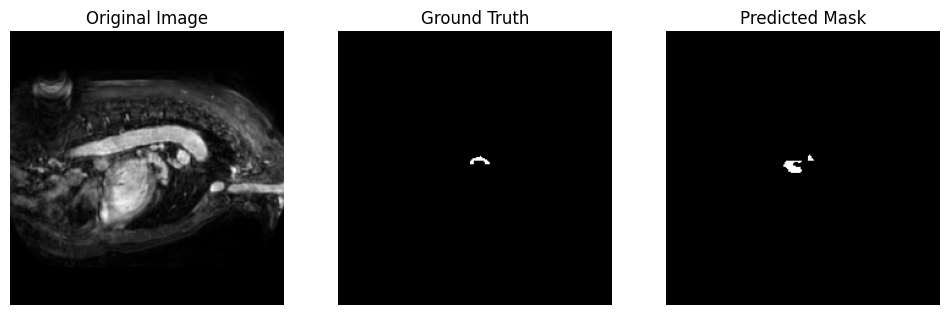

[5|6] dice Score: 0.20275633037090302, label_sum: 100, pred_sum: 117


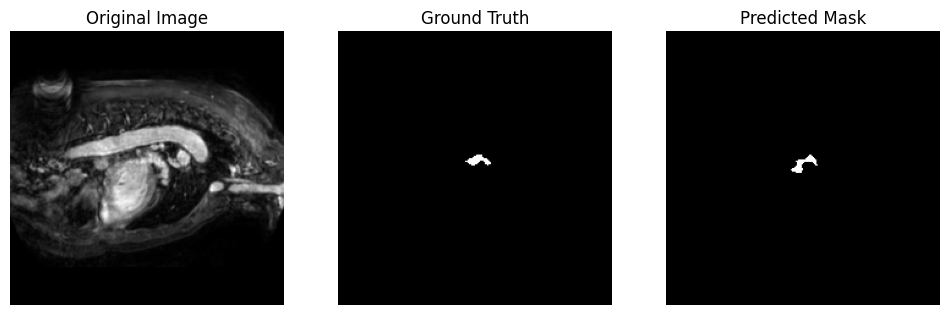

[5|7] dice Score: 0.24016176164150238, label_sum: 141, pred_sum: 128


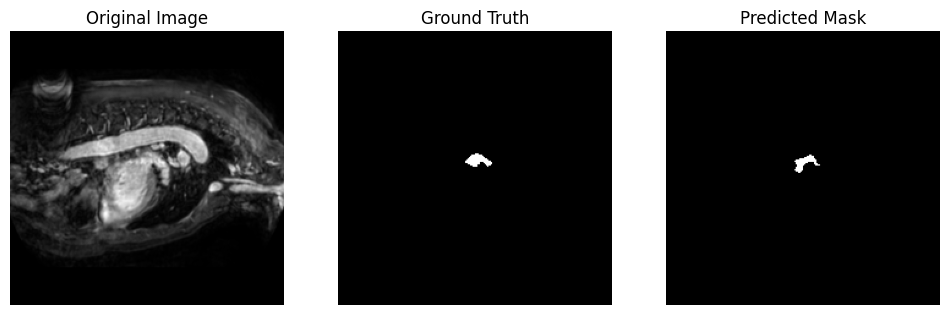

[6|0] dice Score: 0.5957614183425903, label_sum: 193, pred_sum: 150


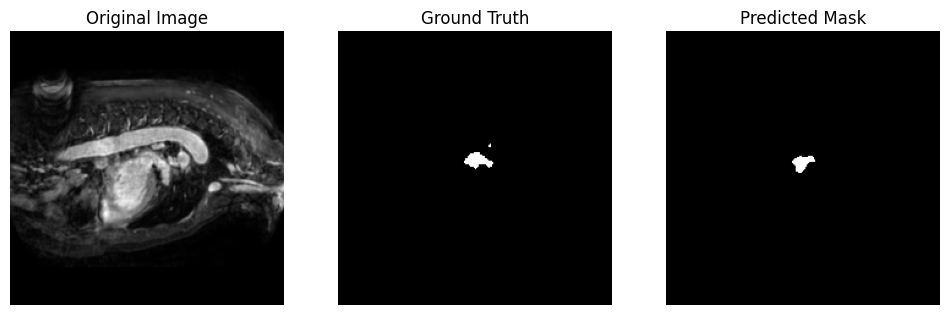

[6|1] dice Score: 0.6398652791976929, label_sum: 213, pred_sum: 166


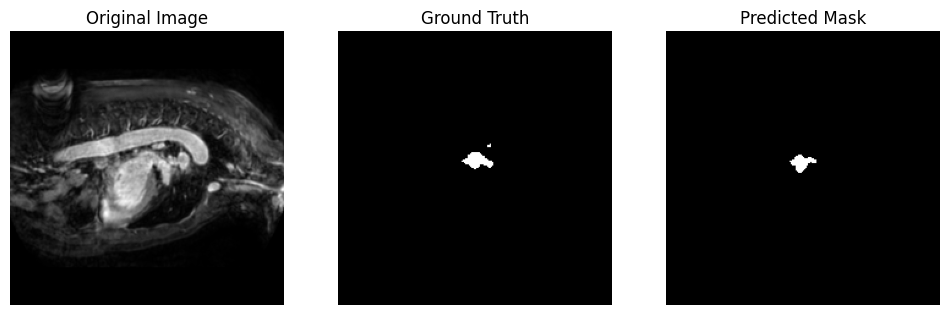

[6|2] dice Score: 0.7151992321014404, label_sum: 250, pred_sum: 226


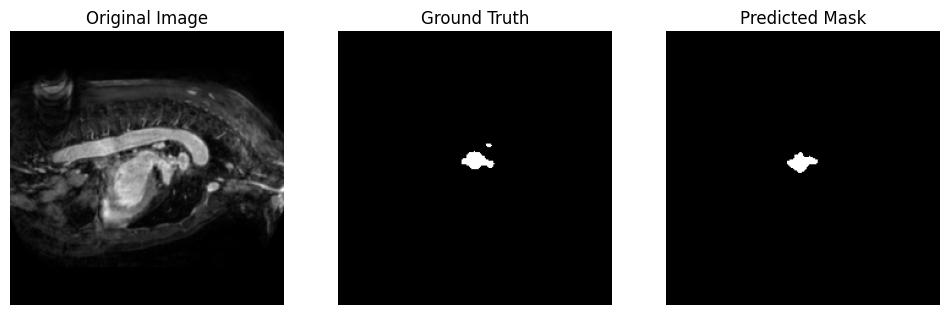

[6|3] dice Score: 0.7774635553359985, label_sum: 277, pred_sum: 261


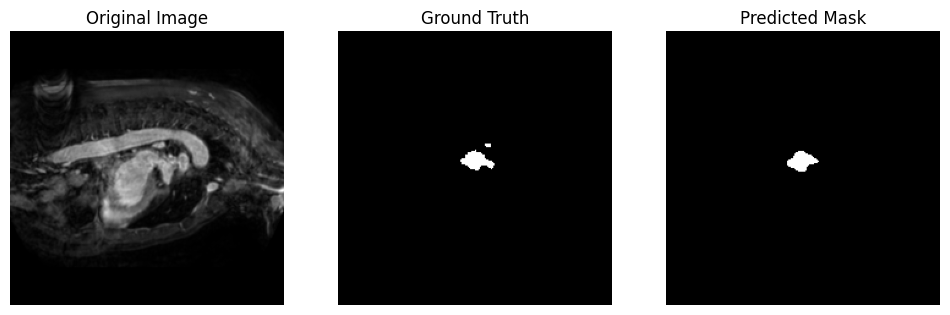

[6|4] dice Score: 0.7905474901199341, label_sum: 305, pred_sum: 263


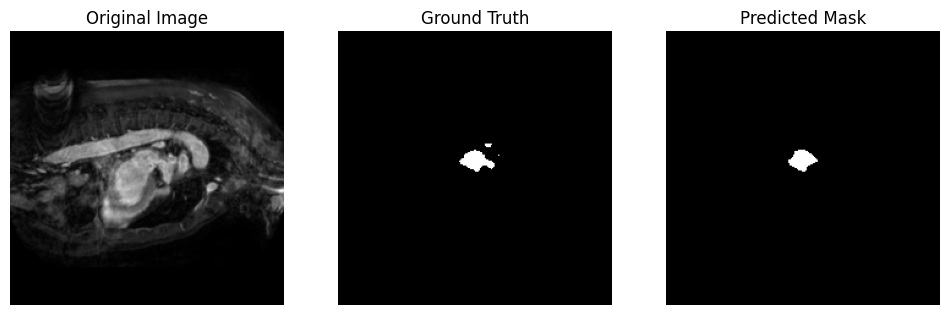

[6|5] dice Score: 0.7822560667991638, label_sum: 338, pred_sum: 268


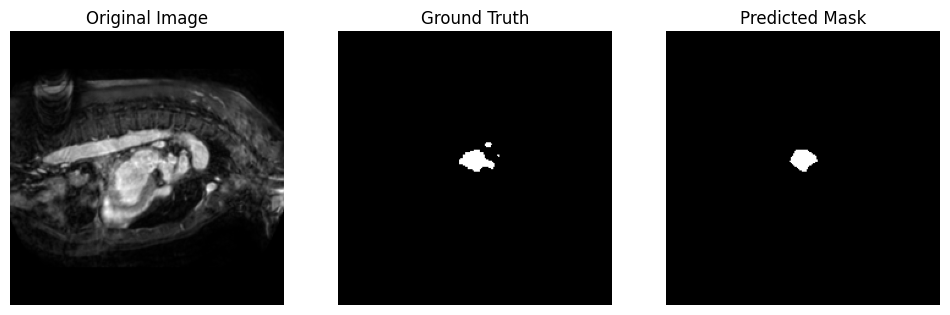

[6|6] dice Score: 0.7768003940582275, label_sum: 370, pred_sum: 277


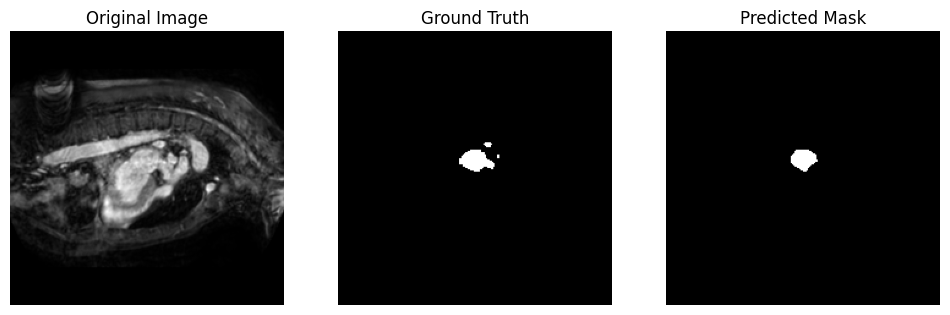

[6|7] dice Score: 0.7668734788894653, label_sum: 426, pred_sum: 340


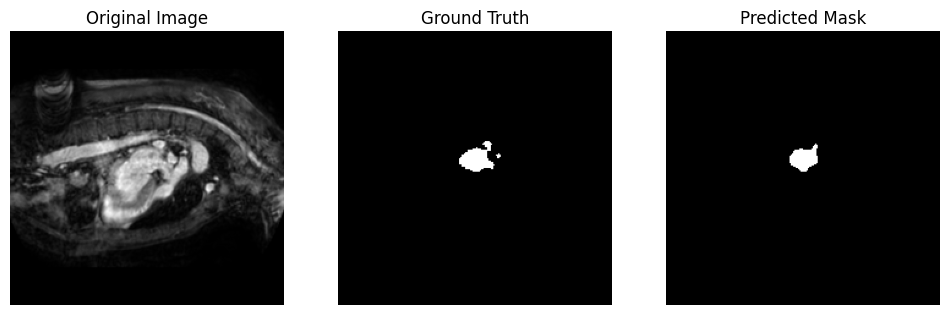

[7|0] dice Score: 0.8108129501342773, label_sum: 471, pred_sum: 389


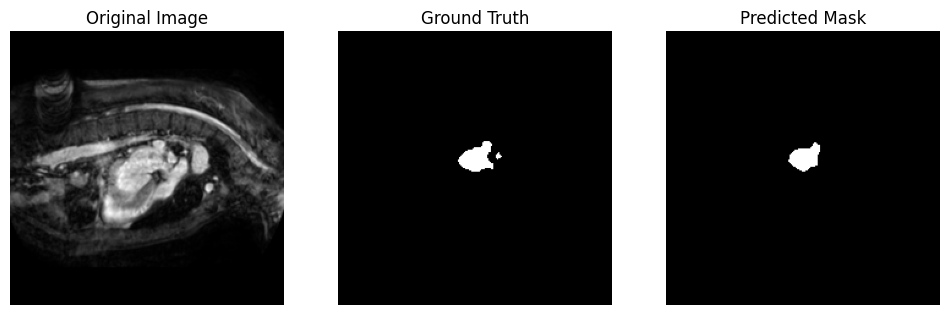

[7|1] dice Score: 0.8796013593673706, label_sum: 514, pred_sum: 468


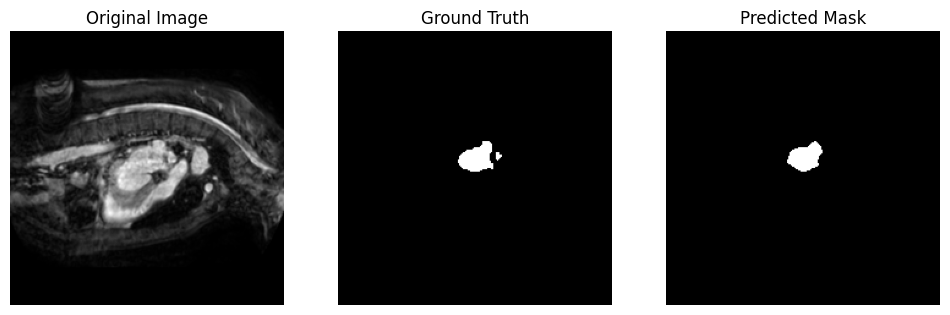

[7|2] dice Score: 0.894310474395752, label_sum: 544, pred_sum: 516


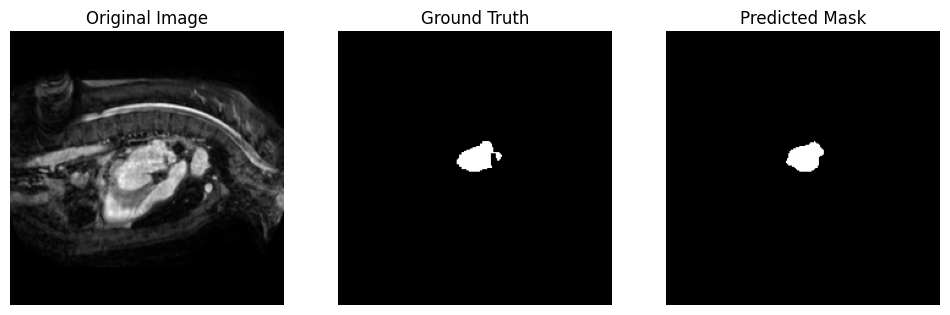

[7|3] dice Score: 0.9017163515090942, label_sum: 570, pred_sum: 554


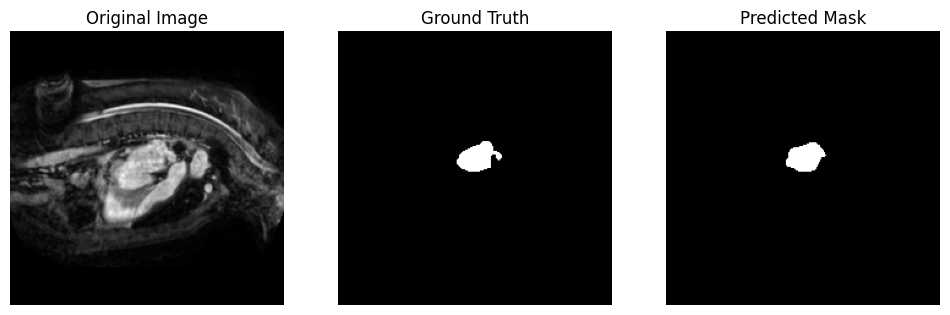

[7|4] dice Score: 0.9142999053001404, label_sum: 589, pred_sum: 561


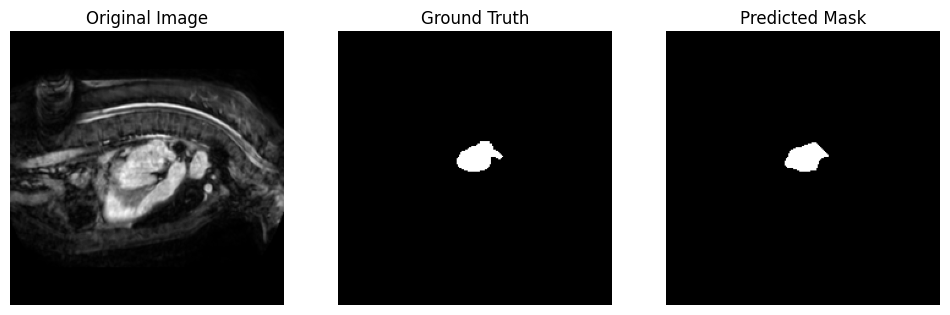

[7|5] dice Score: 0.911449670791626, label_sum: 602, pred_sum: 561


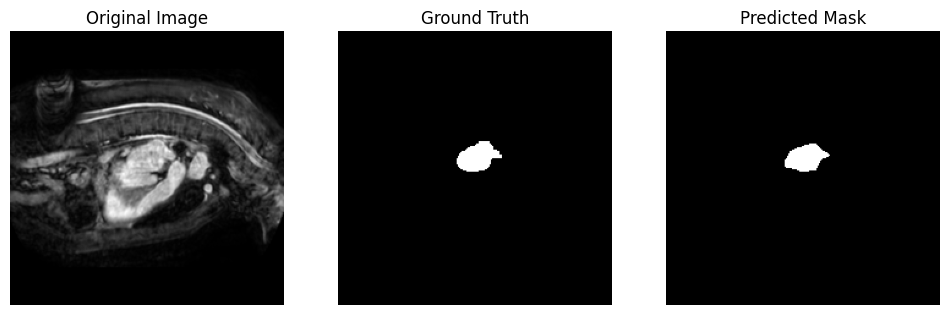

[7|6] dice Score: 0.9073511362075806, label_sum: 606, pred_sum: 565


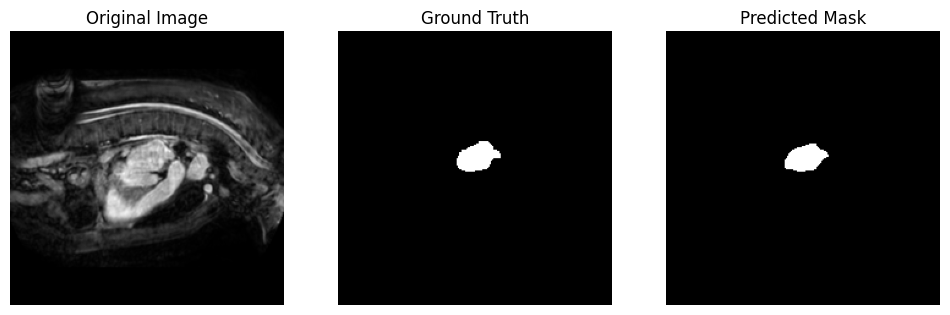

[7|7] dice Score: 0.9001899361610413, label_sum: 606, pred_sum: 576


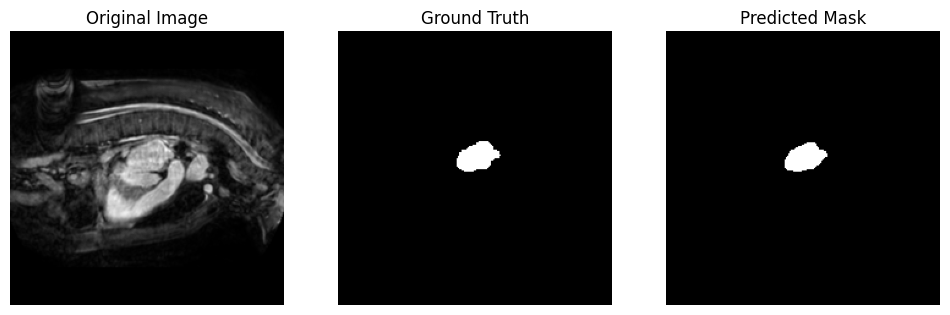

[8|0] dice Score: 0.9208400249481201, label_sum: 614, pred_sum: 542


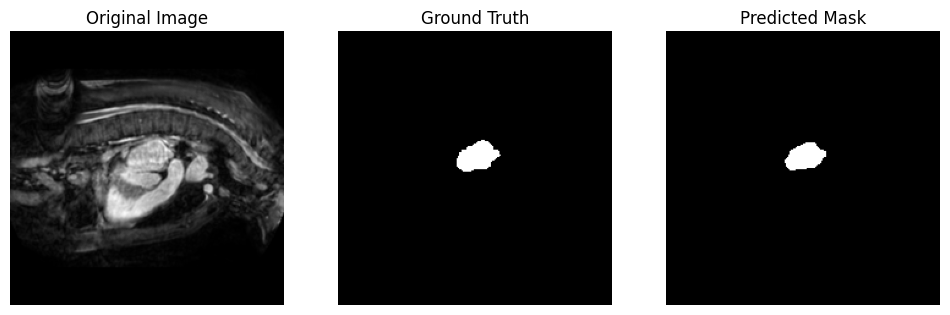

[8|1] dice Score: 0.8901869654655457, label_sum: 610, pred_sum: 497


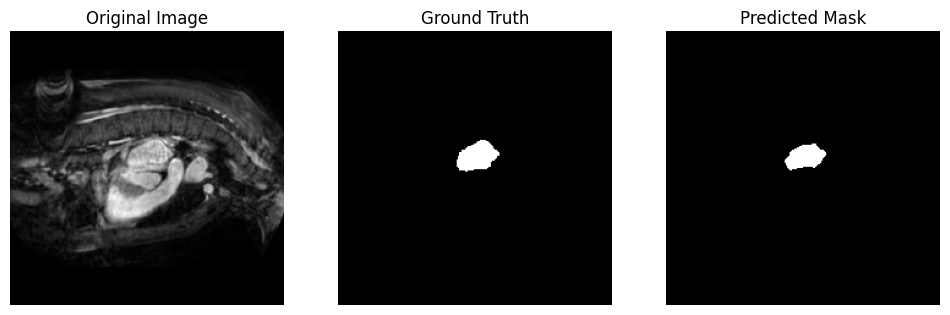

In [63]:
max_number_of_images_to_print = 20
label_has_white = True # Set to True if you only want to see labels (ground truth) that have white pixels
pred_has_white = False # Set to True if you only want to see predictions that has white pixels
log = False # Set to True if you want the dice_coefficient() to print log messages
Infer(model, test_dl, max_number_of_images_to_print, label_has_white, pred_has_white, log)